<b><font color='darkred'>
RNN - Recurrent Neural Network
-----------------
➔ Einfaches RNN-Netz

- mit GRU-Zellen
- Versuch mit größerer Subsample-Länge schlechtere Ergebnisse


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import model_selection
from tensorflow import keras
import keras_tuner as kt
import helper

/Users/melanie/Library/Python/3.9/lib/python/site-packages/urllib3/__init__.py:35: NotOpenSSLWarning: urllib3 v2 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [2]:
best_subsample_size = 32
SCALE = 2000

In [3]:
zugversuche, kurven, versuche_train, versuche_test = helper.read_data()

In [4]:
versuche_train_valid, versuche_test_valid = model_selection.train_test_split(versuche_train, test_size=0.1, random_state=42)
versuche_train_valid.shape, versuche_test_valid.shape, versuche_test.shape

# versuche_train       = versuche_train_valid
# versuche_train_valid = versuche_train
# versuche_test_valid  = versuche_valid

((432, 5), (48, 5), (120, 5))

In [5]:
subsample = helper.Subsample(best_subsample_size)
subsample.fit()

Subsample(subsample=32)

In [6]:
X_train = subsample.transform(versuche_train_valid.key, kurven)
label_train      = versuche_train_valid.label.values
festigkeit_train = versuche_train_valid.festigkeit.values

print(X_train.shape, label_train.shape)
print(X_train.max(axis=(0,1)))

X_valid = subsample.transform(versuche_test_valid.key, kurven)
label_valid      = versuche_test_valid.label.values
festigkeit_valid = versuche_test_valid.festigkeit.values

print(X_valid.shape, label_valid.shape)
print(X_valid.max(axis=(0,1)))

X_test = subsample.transform(versuche_test.key, kurven)
label_test      = versuche_test.label.values
festigkeit_test = versuche_test.festigkeit.values

print(X_test.shape)
print(X_test.max(axis=(0,1)))

(432, 32, 3) (432,)
[3563.91   625.019    4.14 ]
(48, 32, 3) (48,)
[3419.39   623.066    3.98 ]
(120, 32, 3)
[3532.82   623.066    3.82 ]


<b><font color='lightgreen'> Daten skalieren

In [7]:
tsMaxScale = helper.TsMaxScaler()
X_train_scaled = tsMaxScale.fit_transform(X_train)
X_valid_scaled = tsMaxScale.transform(X_valid)
X_test_scaled = tsMaxScale.transform(X_test)

festigkeit_train = festigkeit_train/SCALE
festigkeit_valid = festigkeit_valid/SCALE
festigkeit_test  = festigkeit_test/SCALE

<b><font color='lightgreen'> Darstellung der Schweisskurven X_train

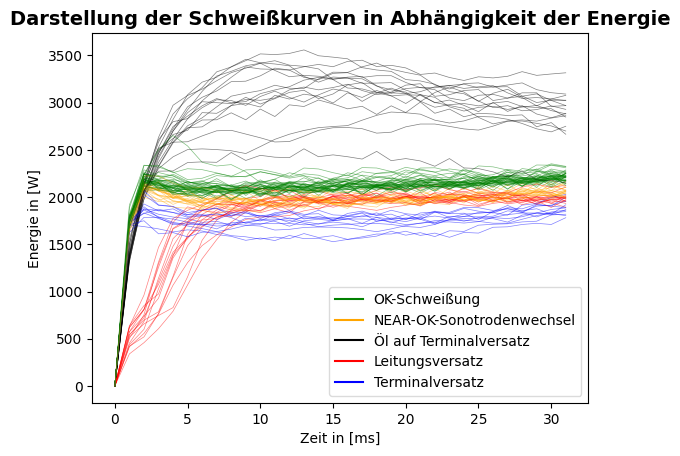

In [8]:
helper.plot_curves(X_train[:100,:,:], 0, label_train[:100], 'power')

<font color='lightgreen'> alle features verwenden

In [9]:
dims = X_train.shape
X2_train = X_train_scaled
X2_valid = X_valid_scaled
X2_test  = X_test_scaled
X2_train.shape

(432, 32, 3)

<font color='lightgreen'><b>Hyperparametersuche</b>

- mehrere GRU-Schichten
- ein breiter Dense-Layer
- ein Dense-Layer zum Zusammenfassen
- Umskalieren Ergebnis

In [10]:
def build_class(hp):
    n_gru = hp.Int("n_gru", min_value=2, max_value=6, default=2)
    #n_hidden = hp.Int("n_hidden", min_value=1, max_value=5, default=2)
    n_neurons = hp.Int("n_neurons", min_value=64, max_value=512)
    learning_rate = hp.Float("learning_rate", min_value=1e-4, max_value=5e-3, sampling='log')
    model = keras.models.Sequential()
    model.add(keras.layers.Input(shape=X2_train.shape[1:]))
    for _ in range(n_gru-1):
        model.add(keras.layers.GRU(n_neurons, return_sequences=True))
    model.add(keras.layers.GRU(n_neurons))
    model.add(keras.layers.Dense(n_neurons, use_bias=False))
    model.add(keras.layers.BatchNormalization())
    model.add(keras.layers.Activation('relu'))
    model.add(keras.layers.Dense(1, activation='relu'))
    model.add(keras.layers.Lambda(lambda x: x*2000.0))
    model.compile(
        loss='mse',
        optimizer=keras.optimizers.Adam(learning_rate=learning_rate),
    )
    return model

In [11]:
random_search_tuner = kt.RandomSearch(
    build_class, 
    objective='val_loss', 
    max_trials=20,
    overwrite=True, 
    directory='Modelle/rnn', project_name='rnn_reg',
)
random_search_tuner.search(X2_train, festigkeit_train, epochs=30, batch_size=8,
    validation_data=(X2_valid, festigkeit_valid)
)

Trial 20 Complete [00h 01m 55s]
val_loss: 1.5367060899734497

Best val_loss So Far: 1.5367060899734497
Total elapsed time: 00h 58m 31s


In [12]:
model_reg = random_search_tuner.get_best_models(num_models=1)[0]
hp = random_search_tuner.get_best_hyperparameters(num_trials=1)[0]
hp.values

{'n_gru': 4, 'n_neurons': 482, 'learning_rate': 0.00018181897540706427}

In [13]:
model_reg = keras.models.Sequential()
model_reg.add(keras.layers.Input(shape=X2_train.shape[1:]))
model_reg.add(keras.layers.GRU(128, return_sequences=True))
model_reg.add(keras.layers.GRU(128, return_sequences=True))
model_reg.add(keras.layers.GRU(128, return_sequences=True))
model_reg.add(keras.layers.GRU(128))
model_reg.add(keras.layers.Dense(100, activation='relu'))
model_reg.add(keras.layers.Dense(1))
model_reg.add(keras.layers.Lambda(lambda x: x*2000))

model_reg.compile(
    loss='mse',
    optimizer=keras.optimizers.Nadam(learning_rate=0.0008)
)

model_reg.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 gru_4 (GRU)                 (None, 32, 128)           51072     
                                                                 
 gru_5 (GRU)                 (None, 32, 128)           99072     
                                                                 
 gru_6 (GRU)                 (None, 32, 128)           99072     
                                                                 
 gru_7 (GRU)                 (None, 128)               99072     
                                                                 
 dense_2 (Dense)             (None, 100)               12900     
                                                                 
 dense_3 (Dense)             (None, 1)                 101       
                                                                 
 lambda_1 (Lambda)           (None, 1)                

In [14]:
hist = model_reg.fit(X2_train, festigkeit_train, epochs=30, batch_size=8,
    validation_data=(X2_valid, festigkeit_valid)
)

Epoch 1/30
54/54 [==============================] - 4s 34ms/step - loss: 738.3780 - val_loss: 0.3550
Epoch 2/30
54/54 [==============================] - 1s 27ms/step - loss: 0.3857 - val_loss: 0.6526
Epoch 3/30
54/54 [==============================] - 1s 25ms/step - loss: 5.4266 - val_loss: 16.5633
Epoch 4/30
54/54 [==============================] - 1s 25ms/step - loss: 9.5940 - val_loss: 0.8942
Epoch 5/30
54/54 [==============================] - 1s 25ms/step - loss: 6.5936 - val_loss: 9.8083
Epoch 6/30
54/54 [==============================] - 1s 25ms/step - loss: 3.3793 - val_loss: 6.9213
Epoch 7/30
54/54 [==============================] - 1s 26ms/step - loss: 6.8410 - val_loss: 7.0153
Epoch 8/30
54/54 [==============================] - 1s 25ms/step - loss: 2.0792 - val_loss: 1.2861
Epoch 9/30
54/54 [==============================] - 1s 25ms/step - loss: 2.0904 - val_loss: 4.7482
Epoch 10/30
54/54 [==============================] - 1s 25ms/step - loss: 3.7821 - val_loss: 9.8206
Epoch 

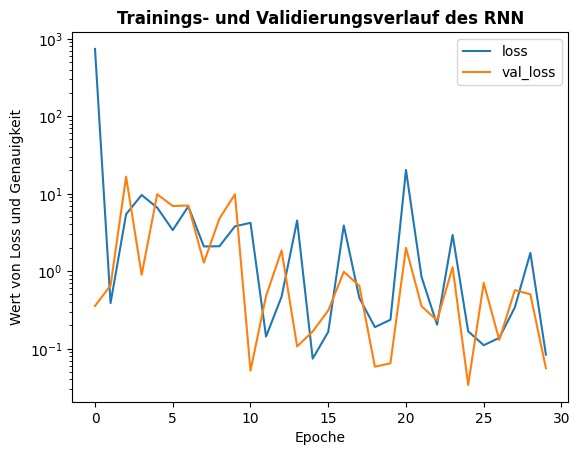

In [15]:
pd.DataFrame(hist.history).plot(logy=True)
plt.xlabel("Epoche")
plt.ylabel("Wert von Loss und Genauigkeit")
plt.title("Trainings- und Validierungsverlauf des RNN", weight='bold')
plt.show()

<b><font color='lightgreen'> Vorhersage Trainings-, Validierungs- und Testdaten

In [16]:
y_pred_train = model_reg.predict(X2_train)
y_pred_test = model_reg.predict(X2_test)
y_pred_valid = model_reg.predict(X2_valid)

2/2 [==============================] - 0s 10ms/step


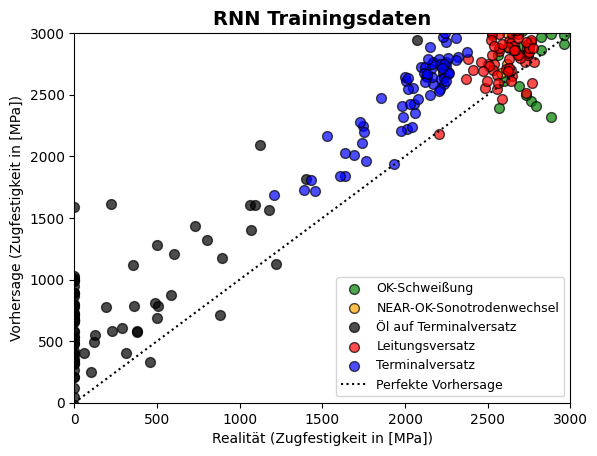

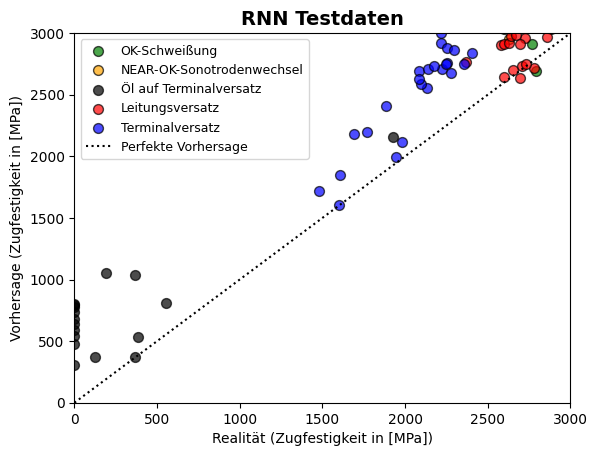

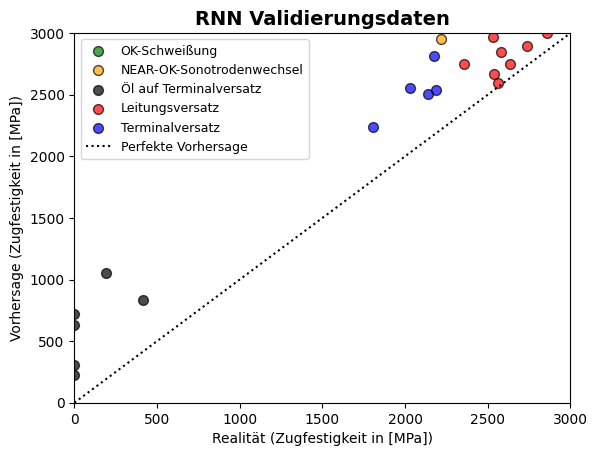

In [17]:
helper.plot_pred(y_pred_train, festigkeit_train, label_train, 'RNN Trainingsdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_test, festigkeit_test, label_test, 'RNN Testdaten', 'mit Linie', SCALE)
helper.plot_pred(y_pred_valid, festigkeit_valid, label_valid, 'RNN Validierungsdaten', 'mit Linie', SCALE)

<b><font color='lightgreen'> Modellbewertung</b>

In [18]:
helper.get_metric_table_regr(festigkeit_train, y_pred_train, festigkeit_test, y_pred_test, SCALE)

,Train,Test
Metric,,
MSE,255053.32,227861.14
RMSE,505.03,477.35
MAE,444.82,426.67
R²,0.72,0.72
